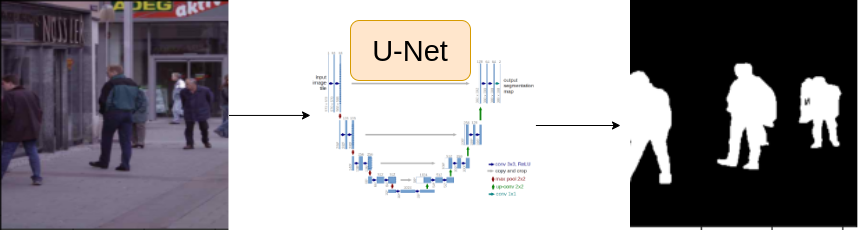
Image segmentation could be thought of as the combination of classification and localization.

In [1]:
import sys
sys.path.append('/Human-Segmentation-Dataset-master')

In [2]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import helper

# Setup Configurations

In [3]:
csv_file = './Human-Segmentation-Dataset-master/train.csv'
data_dir = './image_segmentation/'

device = 'cuda'
epochs = 25
lr = 0.003
img_size = 320
bs = 8

encoder = 'timm-efficientnet-b0'
weights = 'imagenet'

In [4]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


- **2 columns**: 
    - masks is our ground truth/target, stored the path of the masks images.
     - images is our input which contain the path of the images.

In [5]:
## lets see some example ie explore the dataframe
row = df.iloc[3]

image_path, mask_path = row['images'], row['masks']

image, mask = cv2.imread(image_path), cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 

## convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

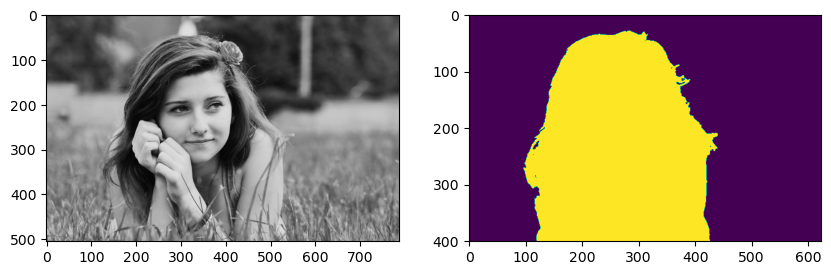

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.imshow(image)
ax2.imshow(mask)

In [7]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Augmentation

In [8]:
import albumentations as A #read more abt albumentations

In [9]:
def getTrainAugs():
    return A.Compose(
        [
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)
        ], is_check_shapes=False
    )

# we are not rotating vertically or horizontally in valid 
# because this will benificial to know at the time of inference.  
def getValidAugs():
    return A.Compose(
        [
            A.Resize(img_size, img_size)        
        ],  is_check_shapes=False
    )

# Create CustomDataset

In [10]:
from torch.utils.data import Dataset,DataLoader

In [11]:
class SegmentationDataset(Dataset):
    def __init__(self, df, aug):
        self.df = df
        self.aug = aug
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['images']
        mask_path = row['masks']
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)# here we will add channel, see below
        mask = np.expand_dims(mask,axis=-1)
        
        if self.aug:
            data = self.aug(image=image, mask=mask)
            image = data['image']
            mask = data['mask']
            
        #our images (h,w,c) now to convert into (c,h,w)
        image = np.transpose(image, (2,0,1)).astype(np.float32 )
        mask = np.transpose(mask, (2,0,1)).astype(np.float32 )
        
        image = torch.Tensor(image) /255.0 #scalling
        mask = torch.round(torch.Tensor(mask)/ 255.0) #round to 0 and 1
        
        return image, mask

In [12]:
train_ds = SegmentationDataset(train_df, getTrainAugs())
valid_ds = SegmentationDataset(valid_df, getValidAugs())

In [13]:
print(f'size of trainset: {len(train_ds)} \n size of validset: {len(valid_ds)}')

size of trainset: 232 
 size of validset: 58


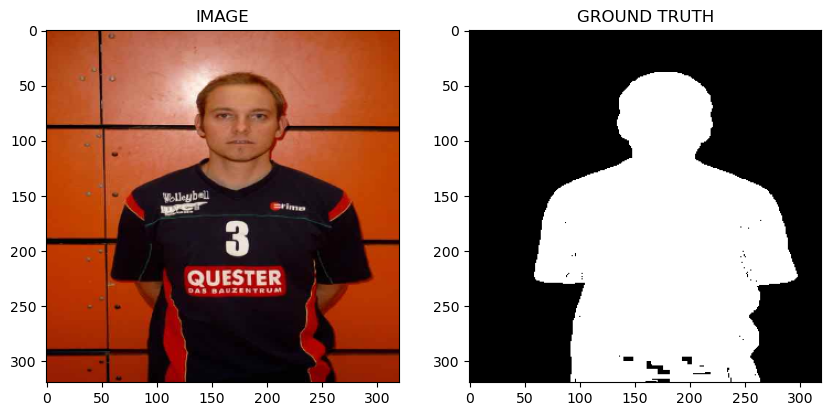

In [14]:
## lets check the for perticular index ex: idx=3
idx=12
image, mask = train_ds[idx]
helper.show_image(image, mask)

# Load Dataset into batches

In [15]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True)

In [16]:
print(f'Total TrainLoader batches: {len(train_dl)} \n Total ValidLoader batches: {len(valid_dl)}')

Total TrainLoader batches: 29 
 Total ValidLoader batches: 8


In [17]:
# lets see the shape of 1 batch
image, mask = next(iter(train_dl))
image.shape, mask.shape #we no.of images, channel, h, w 

(torch.Size([8, 3, 320, 320]), torch.Size([8, 1, 320, 320]))

# Create Segmentation Model

In [18]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [19]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.arc = smp.Unet(
            encoder_name=encoder,
            encoder_weights=weights,
            in_channels=3, 
            classes=1,
            activation= None
        )
    
    def forward(self, images, masks=None):
        logits = self.arc(images)
        
        if masks!=None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1+loss2
        
        return logits

In [20]:
model = SegmentationModel()
model.to(device);

# Create Training and Validation Function

In [21]:
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    
    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss/len(data_loader)


def eval_fn(data_loader, model, optimizer):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)

            logits, loss = model(images, masks)

            total_loss += loss.item()
        
    return total_loss/len(data_loader)

# Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr)

In [ ]:
best_validation_loss = np.Inf

for i in range(epochs):
    train_loss = train_fn(train_dl, model, optimizer)
    valid_loss = eval_fn(train_dl, model, optimizer)
    
    if valid_loss<best_validation_loss:
        torch.save(model.state_dict(), 'best_model.pt',)
        print('model saved')
        best_validation_loss = valid_loss
    print(f'| Epoch: {i+1} |  train loss: {train_loss} | valid loss: {valid_loss}')

# Inference

In [ ]:
import os
os.getcwd()

In [26]:
idx =2

model.load_state_dict(torch.load('./best_model.pt'))
image, mask = valid_ds[idx]

logits_mask = model(image.to(device).unsqueeze(0)) #(c,h,w)->(b,c,h,w)
preds_mask = torch.sigmoid(logits_mask)
preds_mask = (preds_mask > 0.5)*1.0

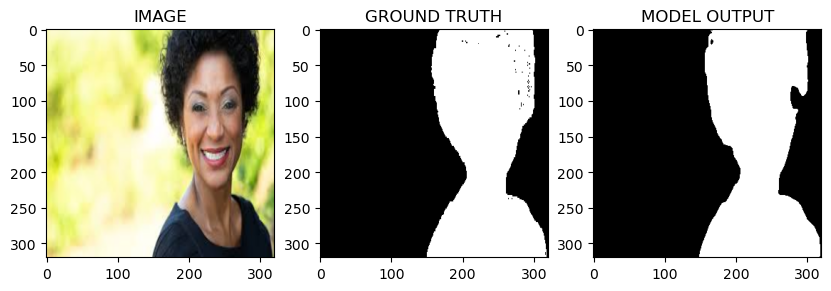

In [27]:
helper.show_image(image, mask, preds_mask.detach().cpu().squeeze(0))

In [ ]:
## if u face any gpu issue try few solution shown below

## 1. removeing cache
# import torch
# torch.cuda.empty_cache()

In [ ]:
## 2. removing extr/unused variable
# import gc
# del variables
# gc.collect()

In [ ]:
## 3. Restart the gpu 
# - sudo rmmod nvidia_uvm
# - sudo modprobe nvidia_uvm